In [192]:
import os.path
import warnings

from Model.radiation.real_gas_data.hitran import LookupTableFolder
from Model.radiation.real_gas_data.specific_humidity import p_altitude_convert
from centa_presentation.base import get_olr_area

warnings.filterwarnings("ignore") # ignore all warnings in this notebook
import matplotlib.pyplot as plt
from Model.radiation.base import round_any
import Model.radiation.real_gas_data.hitran as hitran
import Model.radiation.real_gas_data.specific_humidity as humidity
from Model.radiation.real_gas_data.temperature_profiles import earth_temp, fixed_tropopause_temp, two_lapse_temp
from Model.radiation.real_gas import RealGas, transmission, B_wavenumber, optical_depth, sigma
from IPython.display import HTML
import numpy as np
import os
from tqdm.notebook import tqdm
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')
import sys
sys.path.append('/Users/joshduffield/Documents/StAndrews/Isca/')
from isca_tools.plot import label_subplots, fig_resize, update_linewidth, update_fontsize, savefig

### Gray gas absorption coefficient
The absorption coefficient of a gray gas is $\kappa=1$ at all wavenumbers as indicated below.

gray file exists


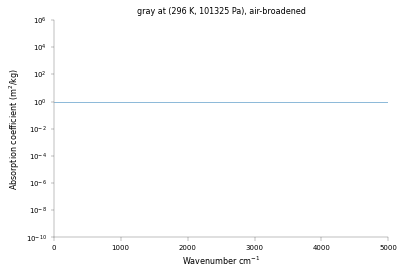

In [2]:
if os.path.isfile(LookupTableFolder + 'gray.npy'):
    print('gray file exists')
    hitran.plot_absorption_coefficient('gray', hitran.p_reference, 270)
else:
    # Just edit single line molecule, but make 1 everywhere
    sing_line_lookup = np.load(f'{LookupTableFolder}/single_line.npy',
                               allow_pickle=True).item();
    # sing_line_lookup['absorption_coef'] *= 0
    # sing_line_lookup['absorption_coef'] += 1
    sing_line_lookup['nu'] = np.arange(0, 5000+hitran.table_dnu, hitran.table_dnu)
    sing_line_lookup['absorption_coef'] = np.ones((1, 1, sing_line_lookup['nu'].size))
    np.save(LookupTableFolder + 'gray.npy', sing_line_lookup)

In [3]:
p_toa = 10  # Top of atmosphere pressure for this notebook (Pa)
n_bands = 200 # number of wavenumber bands in this notebook

In [132]:
# plotting info
lw_large = 1.8
im_width = 6.4

default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
ax_linewidth = plt.rcParams['axes.linewidth']

leg_info = {'handlelength': 2, 'labelspacing': 1, 'columnspacing': 0.9, 'handletextpad': 1}       # info for legend
def add_legend(ax, handles=None, labels=None, ncol=1, title=None, loc=None, frameon=False, edgecolor="k", borderpad=None,
               labelspacing=leg_info['labelspacing'], handlelength=leg_info['handlelength'],
               columnspacing=leg_info['columnspacing'], handletextpad=leg_info['handletextpad']):
    if handles is None:
        return ax.legend(ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                 labelspacing=labelspacing, handlelength=handlelength,
                 columnspacing=columnspacing, handletextpad=handletextpad)
    else:
        return ax.legend(handles, labels, ncol=ncol, title=title, loc=loc, frameon=frameon, edgecolor=edgecolor, borderpad=None,
                         labelspacing=labelspacing, handlelength=handlelength,
                         columnspacing=columnspacing, handletextpad=handletextpad)

# adjust update stuff for presentation
fig_resize_use = lambda x: fig_resize(x, im_width, ar=1.9)
update_linewidth_use = lambda x: update_linewidth(x, base_linewidth=0.8)
update_fontsize_use = lambda x: update_fontsize(x, base_fontsize=5.5)

## Temperature profile
The default temperature profile is lapse rate of 6K/km in troposphere, and 0 in stratosphere. This is index `1` in both lapse rate arrays. We also use this profile in the real gas notebook.

The other values in the array are for investigating the role of temperature profile on OLR reduction per unit mass of GHG added.

In [171]:
lapse_trop_array = [8, 6, 4]    # lapse rate in kelvin per km (dry is 9.8)
lapse_rate_trop = lapse_trop_array[1]
lapse_strat_array = [lapse_rate_trop, 0, -lapse_rate_trop]
lapse_strat = lapse_strat_array[1]
h_tropopause = 12 # height of tropopause in km
h_top = 20
temp_surf = 290 # temperature of surface in K
temp_tropopause = temp_surf - lapse_rate_trop * h_tropopause
# temp_profile_use = lambda x: fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
def temp_profile_use(x, y=lapse_strat, y2=lapse_rate_trop):
    return two_lapse_temp(x, h_tropopause, h_top, temp_surf, y2, y)
# def temp_profile_use(x):
#     var = fixed_tropopause_temp(x, h_tropopause, temp_tropopause, temp_surf)
#     var[var<= temp_tropopause] = temp_surf
#     return var

In [172]:
gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (300,'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)


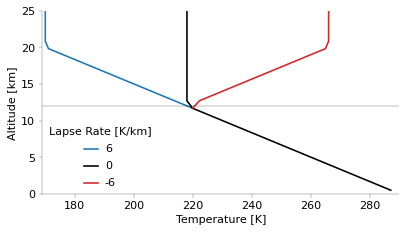

In [173]:
fig, ax = plt.subplots(1, 1)
labels_use = ['All Troposphere', 'Isothermal Stratosphere', 'Inverted Stratosphere']
colors_use = [default_colors[0], 'k', default_colors[3]]
fig_resize_use(fig)
height_plot = p_altitude_convert(p=gray_atmos.p)/1000
for i in range(len(lapse_strat_array)):
    # Only have one line in troposphere
    if i==1:
        mask = height_plot > 0
    else:
        mask = height_plot > h_tropopause-1
    ax.plot(temp_profile_use(gray_atmos.p, lapse_strat_array[i])[mask], height_plot[mask], label=lapse_strat_array[i], color=colors_use[i])
# for i in range(len(lapse_trop_array)):
#     # if i!=1:
#     #     continue
#     ax.plot(temp_profile_use(gray_atmos.p, y2=lapse_trop_array[i]), p_altitude_convert(p=gray_atmos.p)/1000, label=lapse_trop_array[i],
#             color=colors_use[i])
# ax.invert_yaxis()
ax.set_ylim(0, 25)
ax.set_xlim(169, 290)
update_linewidth_use(fig)
ax.axhline(h_tropopause, color='k', lw=ax_linewidth)
add_legend(ax, title='Lapse Rate [K/km]')
update_fontsize_use(fig)
ax.set_xlabel('Temperature [K]')
ax.set_ylabel('Altitude [km]')
plt.show()
# savefig(fig)

In [174]:
co2_conc = np.arange(0, 1000+50, 50)
co2_conc[0] = 1   # otherwise get 0 error
n_conc = co2_conc.size
olr_breakdown = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                                q_funcs={'gray': humidity.constant_q}, q_funcs_args={'gray': (co2_conc[i],'co2')},
                                T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown['atmos'] = olr_breakdown['all'] - olr_breakdown['surface']
olr_tropopause = get_olr_area(gray_atmos, flux=B_wavenumber(gray_atmos.nu_bands['centre'], temp_tropopause)*np.pi)

  0%|          | 0/21 [00:00<?, ?it/s]

In [175]:
linestyle_olr = {'all': '-', 'surface': '--', 'atmos': ':'}
label_olr = {'all': 'Total', 'surface': 'Surface', 'atmos': 'Atmosphere'}

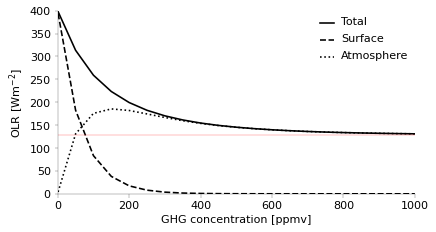

In [176]:
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in olr_breakdown:
    ax.plot(co2_conc, olr_breakdown[key], color='k', linestyle=linestyle_olr[key], label=label_olr[key])
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth_use(fig)
ax.axhline(olr_tropopause, color='r', lw=ax_linewidth)
add_legend(ax)
update_fontsize_use(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_ylabel('OLR [Wm$^{-2}$]')
ax.set_xlim(0, co2_conc[-1])
ax.set_ylim(0, 400)
plt.show()
savefig(fig)

## Location of GHG
Below, we investigate whether it is more effective for a GHG to be added at surface or high in atmosphere.

In [204]:
q_funcs = {'surface': humidity.gradient_q, 'tropopause': humidity.gradient_q}
q_args = {'surface': lambda x: (x, 0, h_tropopause*1000, 'co2'), 'tropopause': lambda x: (0, x, h_tropopause*1000, 'co2')}

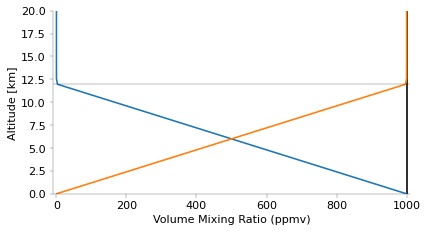

In [219]:
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
ax.axvline(co2_conc[-1], color='k', label='Constant')
for key in q_args:
    ax.plot(humidity.ppmv_from_humidity(
        q_funcs[key](gray_atmos.p, *q_args[key](co2_conc[-1])), 'CO2'),
        p_altitude_convert(p=gray_atmos.p)/1000, label=key.capitalize()+' peak')
ax.set_ylim(0, 20)
ax.set_xlabel('Volume Mixing Ratio (ppmv)')
ax.set_ylabel('Altitude [km]')
ax.set_xlim(-10, 1010)
update_linewidth_use(fig)
ax.axhline(h_tropopause, color='k', lw=ax_linewidth)
# add_legend(ax)
update_fontsize_use(fig)
plt.show()
# savefig(fig)

In [177]:
if lapse_strat != 0:
    raise ValueError('The below stuff is only for lase_strat=0')

In [178]:
olr_breakdown_sfc = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.gradient_q}, q_funcs_args={'gray': (co2_conc[i], 0, h_tropopause*1000, 'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown_sfc['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_sfc['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown_sfc['atmos'] = olr_breakdown_sfc['all'] - olr_breakdown_sfc['surface']

  0%|          | 0/21 [00:00<?, ?it/s]

In [179]:
olr_breakdown_atm = {key: np.zeros(n_conc) for key in ['all', 'surface', 'atmos']}
for i in tqdm(range(n_conc)):
    gray_atmos = RealGas(nz='auto', ny=1, molecule_names=['gray'], p_toa=p_toa,
                            q_funcs={'gray': humidity.gradient_q}, q_funcs_args={'gray': (0, co2_conc[i], h_tropopause*1000, 'co2')},
                            T_func=temp_profile_use, n_nu_bands=n_bands)
    olr_breakdown_atm['all'][i] = get_olr_area(gray_atmos)
    var = gray_atmos.get_flux(include_olr_breakdown=True)[2]
    olr_breakdown_atm['surface'][i] = get_olr_area(gray_atmos, flux=var['surface'])
olr_breakdown_atm['atmos'] = olr_breakdown_atm['all'] - olr_breakdown_atm['surface']

  0%|          | 0/21 [00:00<?, ?it/s]

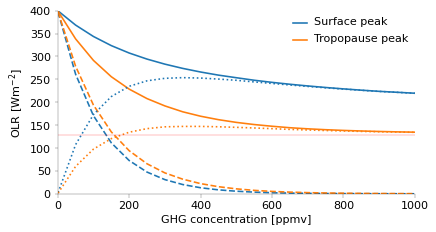

In [212]:
fig, ax = plt.subplots(1, 1)
fig_resize_use(fig)
for key in olr_breakdown_sfc:
    # ax.plot(co2_conc, olr_breakdown[key], color='k', linestyle=linestyle_olr[key], label='Constant' if key=='all' else None, alpha=0.2)
    ax.plot(co2_conc, olr_breakdown_sfc[key], color=default_colors[0], linestyle=linestyle_olr[key], label='Surface peak' if key=='all' else None)
    ax.plot(co2_conc, olr_breakdown_atm[key], color=default_colors[1], linestyle=linestyle_olr[key], label='Tropopause peak' if key=='all' else None)
# ax.plot(co2_conc, olr_breakdown['atmos'])

update_linewidth_use(fig)
ax.axhline(olr_tropopause, color='r', lw=ax_linewidth)
add_legend(ax)
update_fontsize_use(fig)
ax.set_xlabel('GHG concentration [ppmv]')
ax.set_ylabel('OLR [Wm$^{-2}$]')
ax.set_xlim(0, co2_conc[-1])
ax.set_ylim(0, 400)
plt.show()
# savefig(fig)